# Bayesian Estimation Supersedes the t-Test in Bambi

This code reproduces the BEST model and analysis from the [Bayesian Estimation Supersedes the t-Test](https://jkkweb.sitehost.iu.edu/articles/Kruschke2013JEPG.pdf#page=3) paper in Bambi.

See also:
- BEST in PyMC  https://www.pymc.io/projects/examples/en/latest/case_studies/BEST.html


## Data

In [1]:
%load_ext watermark

In [2]:
# DATA
import pandas as pd
treated = [101, 100, 102, 104, 102,  97, 105, 105,  98, 101, 100, 123, 105,
           103, 100,  95, 102, 106, 109, 102,  82, 102, 100, 102, 102, 101,
           102, 102, 103, 103,  97,  97, 103, 101,  97, 104,  96, 103, 124,
           101, 101, 100, 101, 101, 104, 100, 101]
controls = [ 99, 101, 100, 101, 102, 100,  97, 101, 104, 101, 102, 102, 100,
            105,  88, 101, 100, 104, 100, 100, 100, 101, 102, 103,  97, 101,
            101, 100, 101,  99, 101, 100, 100, 101, 100,  99, 101, 100, 102,
            99, 100,  99]
groups = ["treatment"]*len(treated) + ["control"]*len(controls)
iqs = pd.DataFrame({"group": groups, "iq": treated + controls})
iqs

,group,iq
0,treatment,101
1,treatment,100
2,treatment,102
3,treatment,104
4,treatment,102
...,...,...
84,control,100
85,control,102
86,control,99
87,control,100


## Custom prior using Deterministic for nu fails

In [3]:
# MODEL
import bambi as bmb
import numpy as np
import pymc as pm

iqs_mean, iqs_std = iqs["iq"].mean(), iqs["iq"].std()

formula = bmb.Formula("iq ~ 0 + group", "sigma ~ 0 + group")

def ShiftedExponential(name, lam, *args, dims=None, **kwargs):
    exp = pm.Exponential.dist(lam=lam)
    return pm.Deterministic(name, exp+1, *args, dims=dims, **kwargs)

priors = {
    "group": bmb.Prior("Normal", mu=iqs_mean, sigma=1000*iqs_std),
    "sigma": {"group": bmb.Prior("Uniform", lower=np.log(iqs_std/1000), upper=np.log(iqs_std*1000))},
    "nu": bmb.Prior("ShiftedExponential", lam=1/29, dist=ShiftedExponential),
}

# Build model
model = bmb.Model(formula=formula,
                  family="t",
                  link="identity",
                  priors=priors,
                  data=iqs)

# Get model description
print(model)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


       Formula: iq ~ 0 + group
                sigma ~ 0 + group
        Family: t
          Link: mu = identity
                sigma = log
  Observations: 89
        Priors: 
    target = mu
        Common-level effects
            group ~ Normal(mu: 101.1798, sigma: 4744.7622)
        
        Auxiliary parameters
            nu ~ ShiftedExponential(lam: 0.0345)
    target = sigma
        Common-level effects
            sigma_group ~ Uniform(lower: -5.3507, upper: 8.4648)


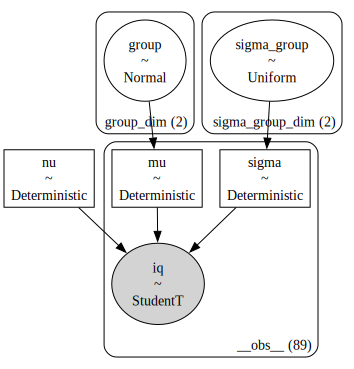

In [4]:
model.build()
model.graph()

Sampling: [group, sigma_group]


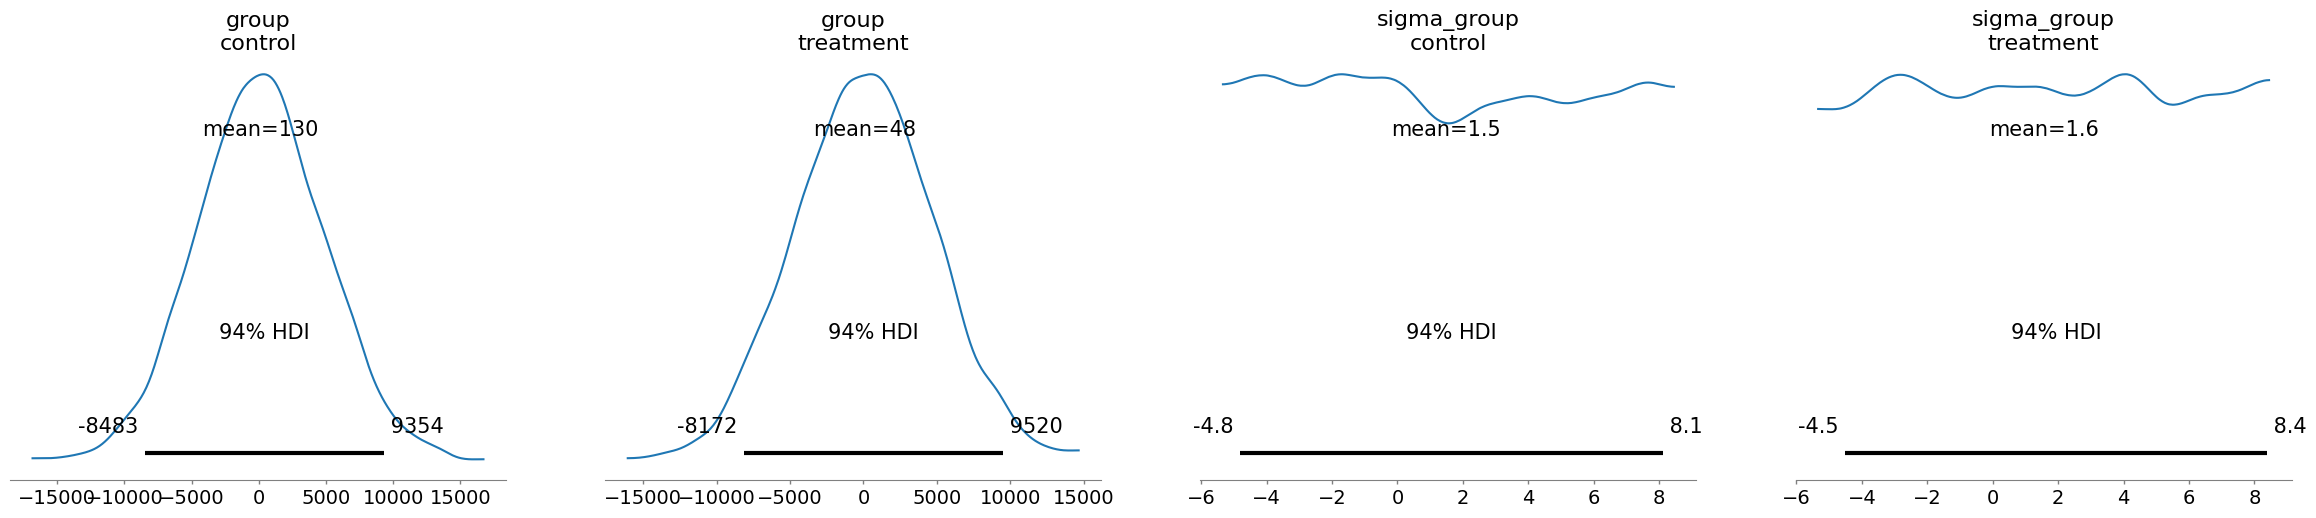

In [5]:
model.plot_priors();

In [6]:
idata = model.fit()

ValueError: Random variables detected in the logp graph: {MeasurableAdd.0, exponential_rv{"()->()"}.out}.
This can happen when DensityDist logp or Interval transform functions reference nonlocal variables,
or when not all rvs have a corresponding value variable.

## Workaround using Truncated exponential for nu

In [7]:
import bambi as bmb
import numpy as np
import pymc as pm

def TruncatedExponential(name, lam, *args, dims=None, **kwargs):
    exp = pm.Exponential.dist(lam=lam)
    return pm.Truncated(name, exp, lower=1, *args, dims=dims, **kwargs)

formula = bmb.Formula("iq ~ 0 + group", "sigma ~ 0 + group")

iqs_mean, iqs_std = iqs["iq"].mean(), iqs["iq"].std()

priorst = {
    "group": bmb.Prior("Normal", mu=iqs_mean, sigma=1000*iqs_std),
    "sigma": {"group": bmb.Prior("Uniform", lower=np.log(iqs_std/1000), upper=np.log(iqs_std*1000))},
    "nu": bmb.Prior("TruncatedExponential", lam=1/29, dist=TruncatedExponential),
}

# Build model
modelt = bmb.Model(formula=formula,
                  family="t",
                  link="identity",
                  priors=priorst,
                  data=iqs)

# Get model description
print(modelt)

       Formula: iq ~ 0 + group
                sigma ~ 0 + group
        Family: t
          Link: mu = identity
                sigma = log
  Observations: 89
        Priors: 
    target = mu
        Common-level effects
            group ~ Normal(mu: 101.1798, sigma: 4744.7622)
        
        Auxiliary parameters
            nu ~ TruncatedExponential(lam: 0.0345)
    target = sigma
        Common-level effects
            sigma_group ~ Uniform(lower: -5.3507, upper: 8.4648)


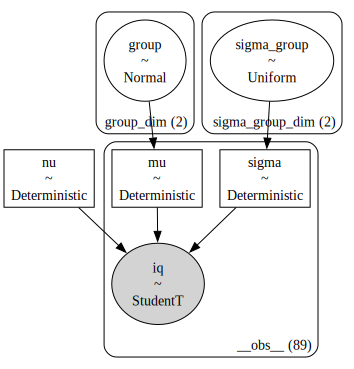

In [8]:
model.build()
model.graph()

In [9]:
idata = modelt.fit(draws=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, group, sigma_group]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 5 seconds.


In [10]:
# Calculate relevant quantities

# Difference posterior of the difference between means
post = idata["posterior"]
post_dmeans = (post["group"][:,:,1] - post["group"][:,:,0])
post["dmeans"] = post_dmeans

# Sigmas from log-sigmas
post["sigma_treatment"] = np.exp(post["sigma_group"][:,:,1])
post["sigma_control"] = np.exp(post["sigma_group"][:,:,0])

# log-nu from nu
post["log_nu"] = np.log10(post["nu"])

# Difference in standard deviations
post["dstd"] = post["sigma_treatment"] - post["sigma_control"]

# Effect size
var_pooled = (post["sigma_treatment"]**2 + post["sigma_control"]**2) / 2
post["cohend"] = post["dmeans"] / np.sqrt(var_pooled)

In [11]:
import arviz as az
az.summary(idata, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
group[control],100.520,0.210,100.113,100.933,0.001,0.001,36813.0,28182.0,1.0
group[treatment],101.551,0.367,100.827,102.280,0.002,0.001,35216.0,27628.0,1.0
nu,1.751,0.444,1.003,2.581,0.003,0.002,22302.0,15491.0,1.0
sigma_group[control],-0.018,0.197,-0.408,0.365,0.001,0.001,31643.0,28912.0,1.0
sigma_group[treatment],0.649,0.212,0.223,1.049,0.001,0.001,29376.0,28177.0,1.0
dmeans,1.030,0.424,0.205,1.863,0.002,0.002,35401.0,27811.0,1.0
sigma_treatment,1.956,0.416,1.186,2.774,0.002,0.002,29376.0,28177.0,1.0
sigma_control,1.002,0.199,0.630,1.391,0.001,0.001,31643.0,28912.0,1.0
log_nu,0.230,0.104,0.027,0.431,0.001,0.000,22302.0,15491.0,1.0
dstd,0.954,0.424,0.151,1.796,0.002,0.002,35849.0,29540.0,1.0


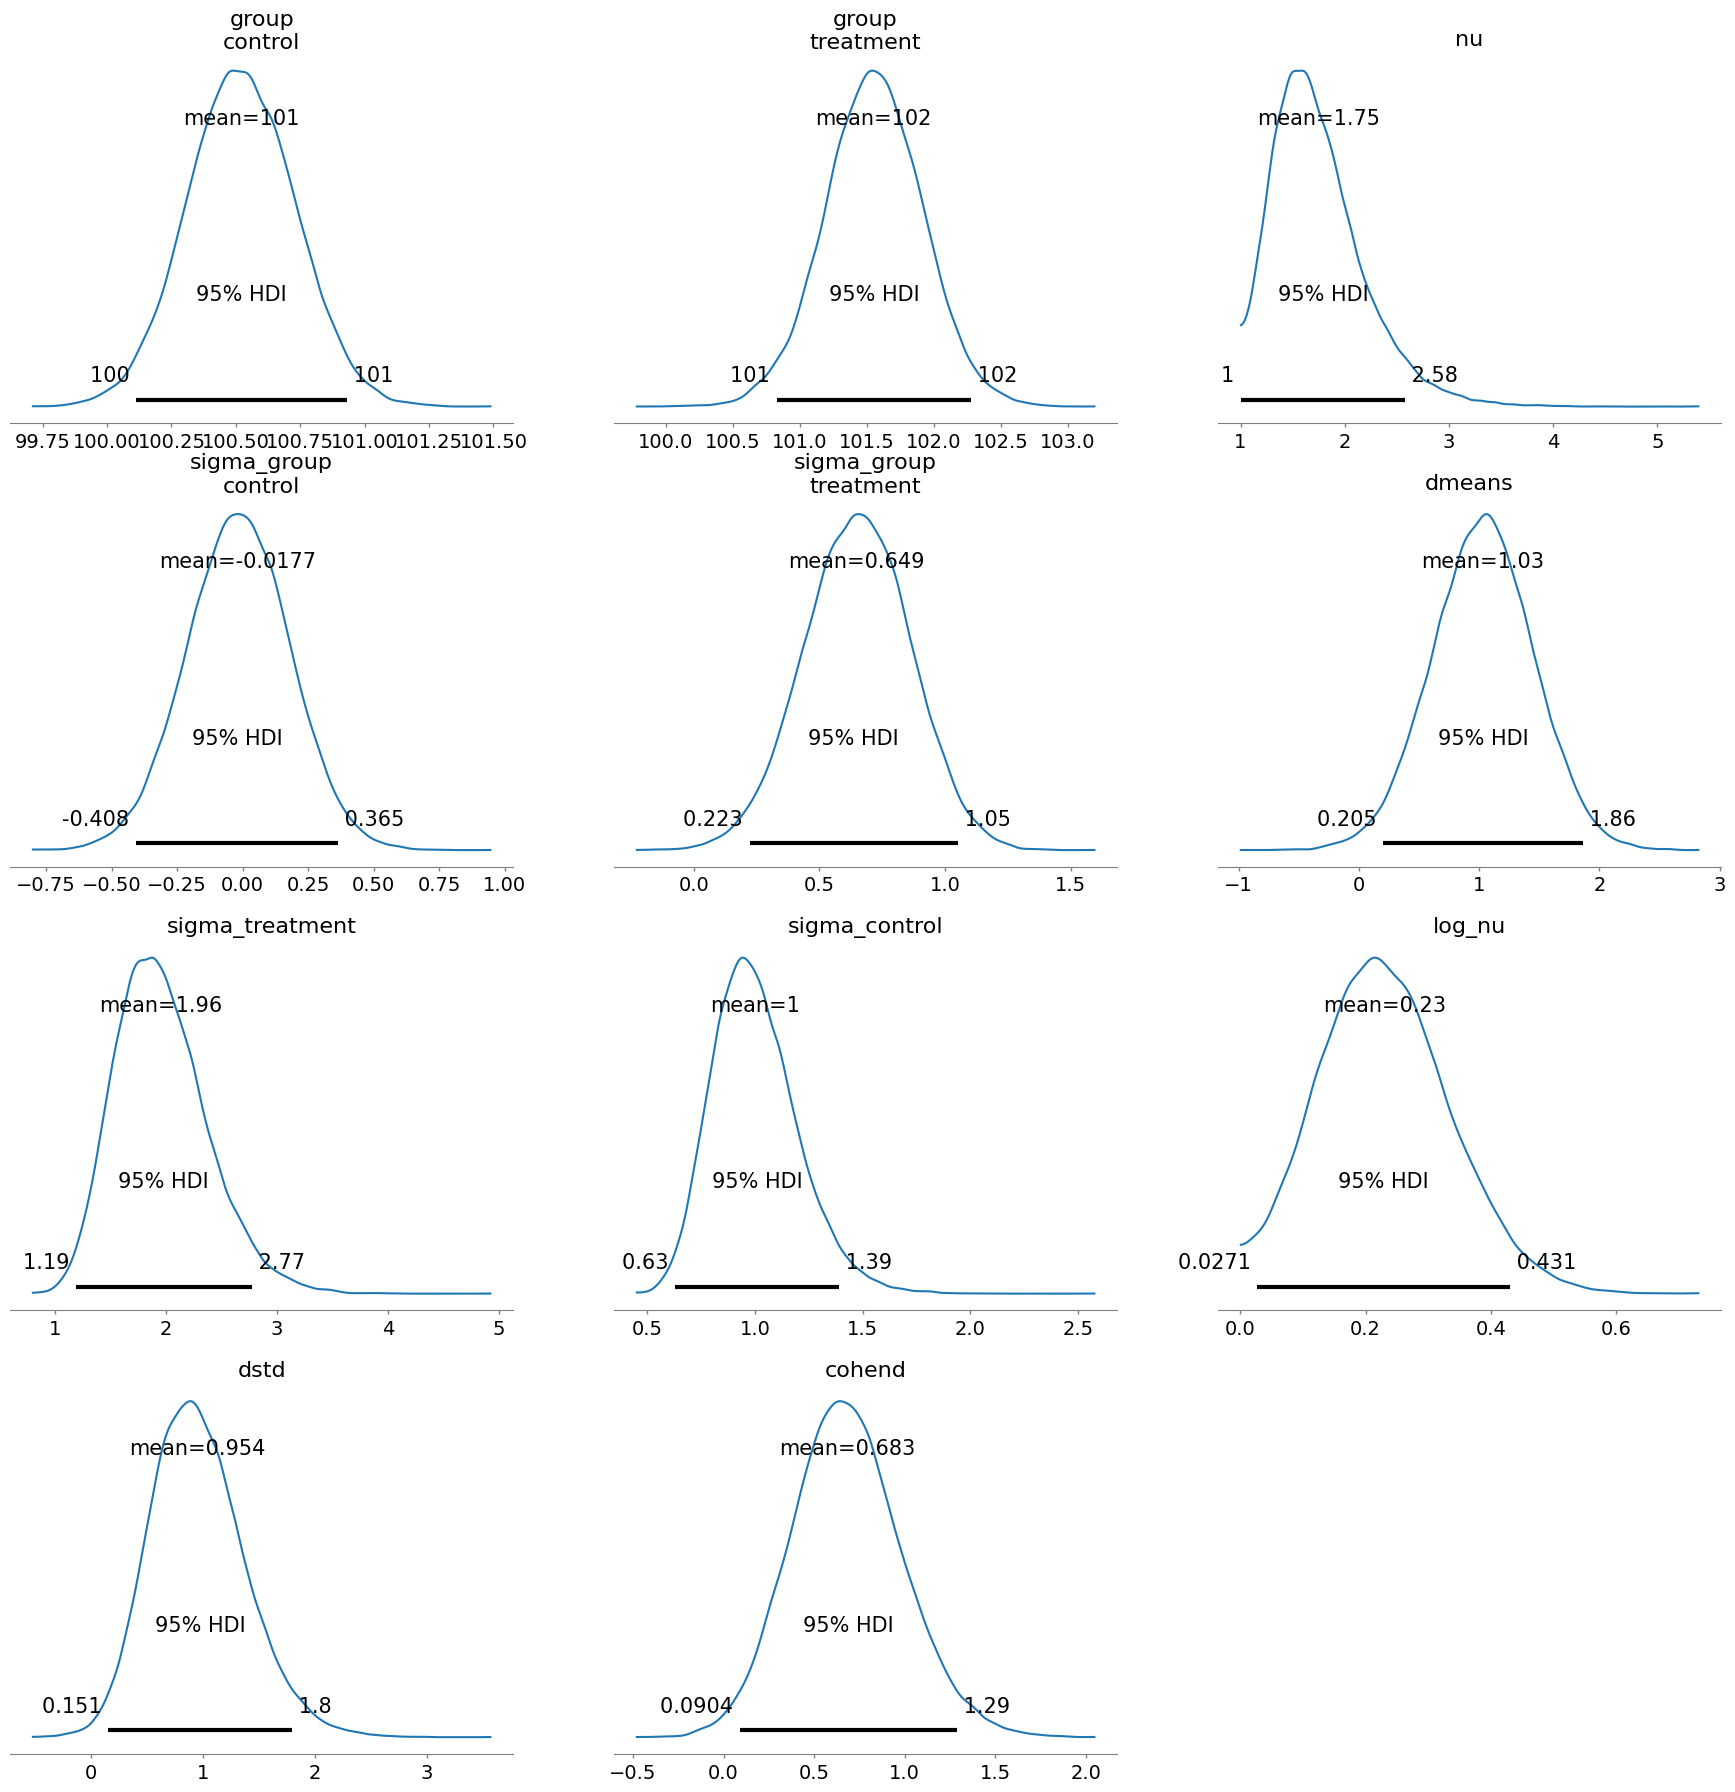

In [12]:
az.plot_posterior(idata, round_to=3, hdi_prob=0.95);

## Another workaround using CustomDist

DOESN'T WORK -- LOTS OF DIVERGENSES

In [29]:
import bambi as bmb
import numpy as np
import pymc as pm

formula = bmb.Formula("iq ~ 0 + group", "sigma ~ 0 + group")

iqs_mean, iqs_std = iqs["iq"].mean(), iqs["iq"].std()

# def ShiftedExpCustomDist(name, lam,  **kwargs):
#     def shited_exp(lam, loc, size):
#         return pm.Exponential.dist(lam=lam) + loc
#     return pm.CustomDist(name, lam, -1, dist=shited_exp, **kwargs)

def dist(lam, shift, size):
    return pm.Exponential.dist(lam, size=size) + shift

priorscd = {
    "group": bmb.Prior("Normal", mu=iqs_mean, sigma=1000*iqs_std),
    "sigma": {"group": bmb.Prior("Uniform", lower=np.log(iqs_std/1000), upper=np.log(iqs_std*1000))},
    #"nu": bmb.Prior("ShiftedExpCustomDist", lam=1/29, dist=ShiftedExpCustomDist),
    "nu": bmb.Prior("ShiftedExponential",
                    lam=1/29, shift=-1.0,
                    dist=lambda name, lam, shift: pm.CustomDist(name, lam, shift, dist=dist, signature="(),()->()"))
}

# Build model
modelcd = bmb.Model(formula=formula,
                    family="t",
                    link="identity",
                    priors=priorscd,
                    data=iqs)

# Get model description
print(modelcd)

       Formula: iq ~ 0 + group
                sigma ~ 0 + group
        Family: t
          Link: mu = identity
                sigma = log
  Observations: 89
        Priors: 
    target = mu
        Common-level effects
            group ~ Normal(mu: 101.1798, sigma: 4744.7622)
        
        Auxiliary parameters
            nu ~ ShiftedExponential(lam: 0.0345, shift: -1.0)
    target = sigma
        Common-level effects
            sigma_group ~ Uniform(lower: -5.3507, upper: 8.4648)


In [30]:
idatacd = modelcd.fit(draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, group, sigma_group]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [19]:
az.summary(idatacd, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
group[control],100.524,0.207,100.124,100.929,0.002,0.002,7167.0,5499.0,1.0
group[treatment],101.550,0.369,100.824,102.252,0.004,0.003,7439.0,5712.0,1.0
nu,1.744,0.458,0.943,2.640,0.007,0.005,5548.0,4573.0,1.0
sigma_group[control],-0.021,0.197,-0.430,0.341,0.002,0.002,6377.0,5018.0,1.0
sigma_group[treatment],0.645,0.211,0.206,1.039,0.003,0.002,5671.0,4772.0,1.0


Sampling: [nu]


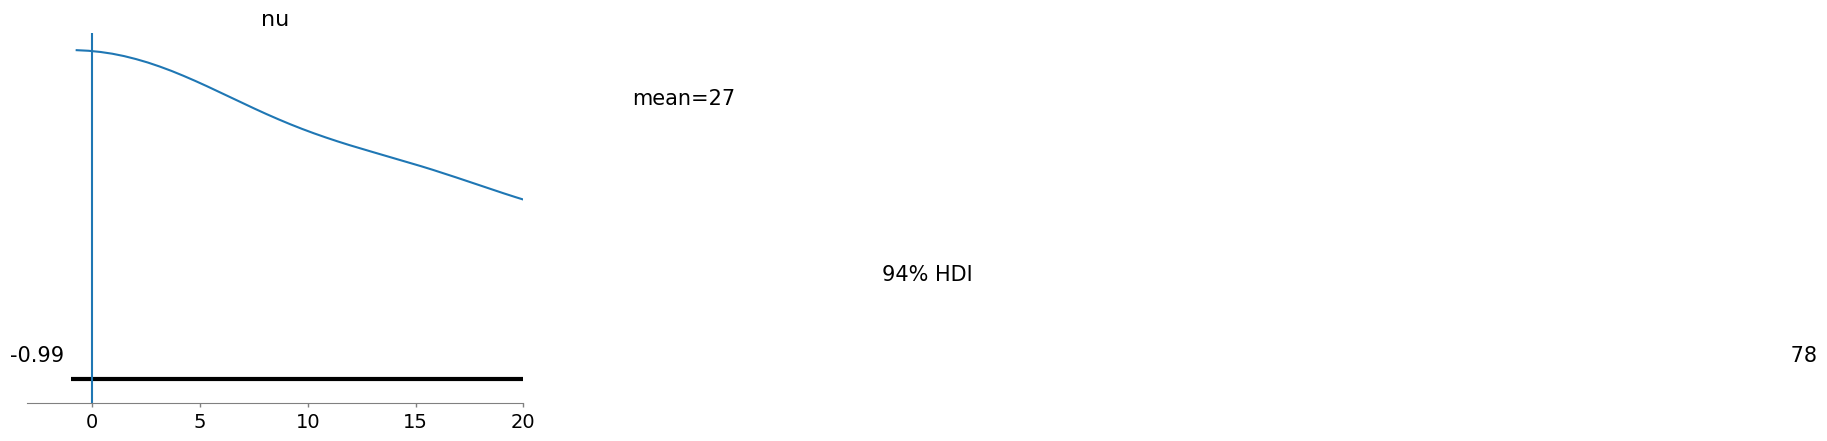

In [31]:
ax = modelcd.plot_priors(var_names=["nu"])
ax.set_xlim([-3,20])
ax.axvline(0)

In [16]:
%watermark -iv

pymc  : 5.18.0
numpy : 1.26.4
bambi : 0.14.1.dev12+g3a30784
arviz : 0.19.0
pandas: 2.2.2

